# Lab: CNN Visualization
*Mark Brubaker & Elias Mann*



In this lab we will be using diifferent techniques for visualiizing and analyzing the inner workings of a convolutional neural network. We will use class activatiion mapping, gradient ascent, circuits, maximal exitation image generation for multi channel filters, and individual channel filter visualization to better understand the VGG19 network. 

In [1]:
import numpy as np
import scipy as sp
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# silence tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# import vgg19 pretrained model from keras
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from keras import models
from keras import backend as K

# getting rid of the warning messages about optimizer graph
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

In [2]:
# print Tensorflow and CUDA information
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
 
if tf.test.gpu_device_name():
    gpu_devices = tf.config.list_physical_devices('GPU')
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    name = details.get('device_name', 'Unknown GPU')
    
    print(f"Using {name}")
else:
    print("No GPU found")

Num GPUs Available:  1
Num CPUs Available:  1
Tensorflow version: 2.11.0
Keras version: 2.11.0
Using NVIDIA GeForce RTX 3070 Laptop GPU


## Choosing a Model
For this analysis we will be visualizing the VGG19 model. VGG19 is a convolutional neural network that is trained on the ImageNet dataset. We chose this model as it has been trained on a large dataset, and does not have residual connections only uses 19 layers and 3X3 convolutional filters. This makes the curcuits easier to create, and model easier to visualize and understand.

In [18]:
# block3_conv2 filter 16 is good for pier.jpg
# block5_conv2 filter 16 is good for dog.jpg
layer_name = 'block3_conv2'
filter_num = 16

# load the model
model = VGG19(weights='imagenet', include_top=True)

# set VGG to be frozen
for layer in model.layers:
    layer.trainable = False

intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer(layer_name).output)

model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

We startt by classifying a few images to ensure that the model is working properly.

1/1 [==============================] - 0s 26ms/step


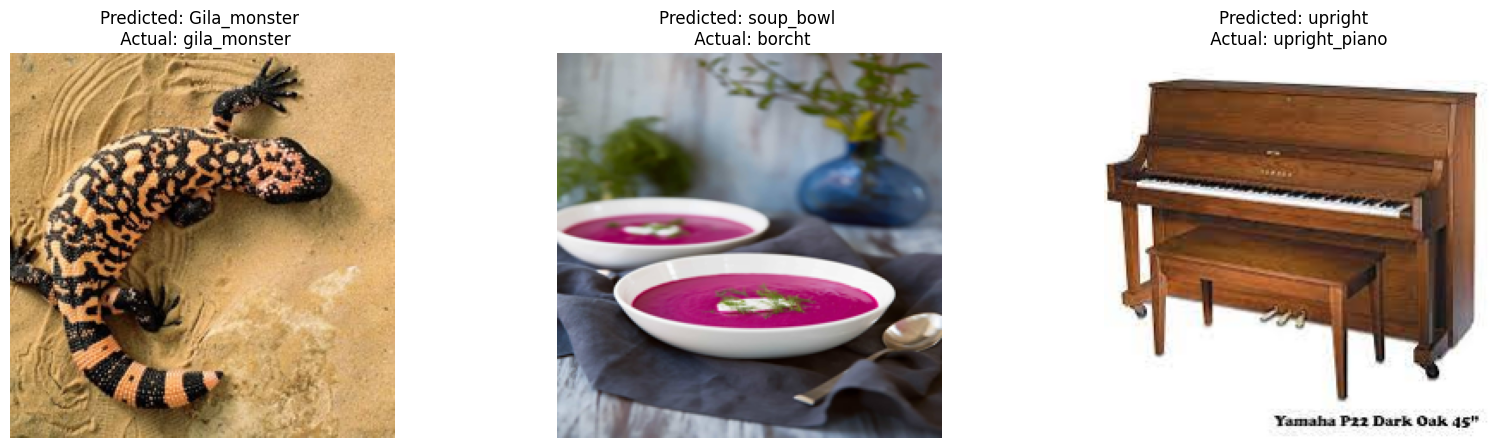

In [4]:
path = 'images/'

# Set up the plot grid
fig, axs = plt.subplots(1, len(os.listdir(path)), figsize=(20, 5))

# Iterate through the images and plot them
for i, filename in enumerate(os.listdir(path)):
    img = Image.open(os.path.join(path, filename)).resize((224, 224))
    x = np.array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    axs[i].imshow(img)
    axs[i].set_title(f'Predicted: {decode_predictions(preds, top=1)[0][0][1]} \n Actual: {filename.split(".")[0]}')
    axs[i].axis('off')

plt.show()


## Selecting A Filter

VGG19 has 19 layers, and we will be analyzing a multi-channel filter from the the 6th called 'block3_conv2' layer since it is an early mid-level layer - it has several convolutional layers before and after it.

In [5]:
#the next two functions are from https://github.com/8000net/LectureNotesMaster/blob/master/04%20LectureVisualizingConvnets.ipynb Dr. Eric Larson's lecture notes

# this funtion scales the image to be between 0 and 255, there are the sizes we will use for display and also the sizes used for VGG19
def prepare_image_for_display(img, norm_type='max'):
    if norm_type == 'max':
        # min/max scaling, best for regular images
        new_img = (img - img.min()) / (img.max()-img.min())
    else:
        # std scaling, best when we are unsure about large outliers
        new_img = ((img - img.mean()) / (img.std() +1e-3))*0.15 + 0.5
        
    new_img *= 255
    new_img = np.clip(new_img, 0, 255)
    
    if len(new_img.shape)>3:
        new_img = np.squeeze(new_img)

        
    return new_img.astype('uint8')


# this function generates the pattern for a given layer and filter using gradient ascent
def generate_pattern(layer_name, filter_index, size=224):
    # Build a model that outputs the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output

    # Isolate the output 
    new_model = models.Model(inputs=model.input, outputs=layer_output)
    
    # We start from a gray image with some uniform noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Create a placeholder for the input image
    I_start = tf.Variable(input_img_data, name='image_var', dtype = 'float64')

    # Preprocess the input image using the same preprocessing as the original images in the dataset
    I = preprocess_input(I_start) # only process once
    # Run gradient ascent for 40 steps
    eta = 1.
    for i in range(40):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            # Watch the input image to compute its gradient with respect to the loss
            tape.watch(I)
            # get variable to maximize 
            model_vals = new_model(I) 

            # Compute the mean activation of the specified filter
            loss = tf.reduce_mean(model_vals[:, :, :, filter_index])

        # Compute the gradient of the input picture w.r.t. this loss
        # add this operation input to maximize
        grad_fn = tape.gradient(loss, I)
        # Normalization trick: we normalize the gradient
        grad_fn /= (tf.sqrt(tf.reduce_mean(tf.square(grad_fn))) + 1e-5) # mean L2 norm
        I += grad_fn * eta # one iteration of maximizing
        
    # return the numpy matrix so we can visualize 
    img = I.numpy()
    return prepare_image_for_display(img, norm_type='std')

# prepare the images for VGG19
def prepare_image_for_vgg(img):
    # convert to numpy array
    x = np.array(img)

    
    if x.ndim == 2:  # grayscale image
        x = np.stack([x, x, x], axis=-1)
    elif x.shape[2] == 4:  # RGBA image
        x = Image.fromarray(x).convert('RGB')
        x = np.array(x)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def plot_heatmap_on_image(image, heatmap, ax, cmap='viridis', alpha=0.5):
    """
    Plots a heatmap on an image.
    :param image: The PIL image object
    :param heatmap: The 2D numpy array representing the heatmap
    :param ax: The matplotlib axis to plot on
    :param cmap: The colormap to use for the heatmap
    :param alpha: The transparency level of the heatmap
    """
    ax.imshow(image)
    im = ax.imshow(heatmap, cmap=cmap, alpha=alpha, extent=(0, 224, 224, 0))
    plt.colorbar(im, ax=ax, shrink=0.7)

When we visualize the filter using gradient ascent. By observng the visualization of this filter, we hypothesize that it detects horizonaltal line. We will test this by using Class Activcation Mapping (CAM) to see if the filter is reactive to horizontal lines on the image of a pier.

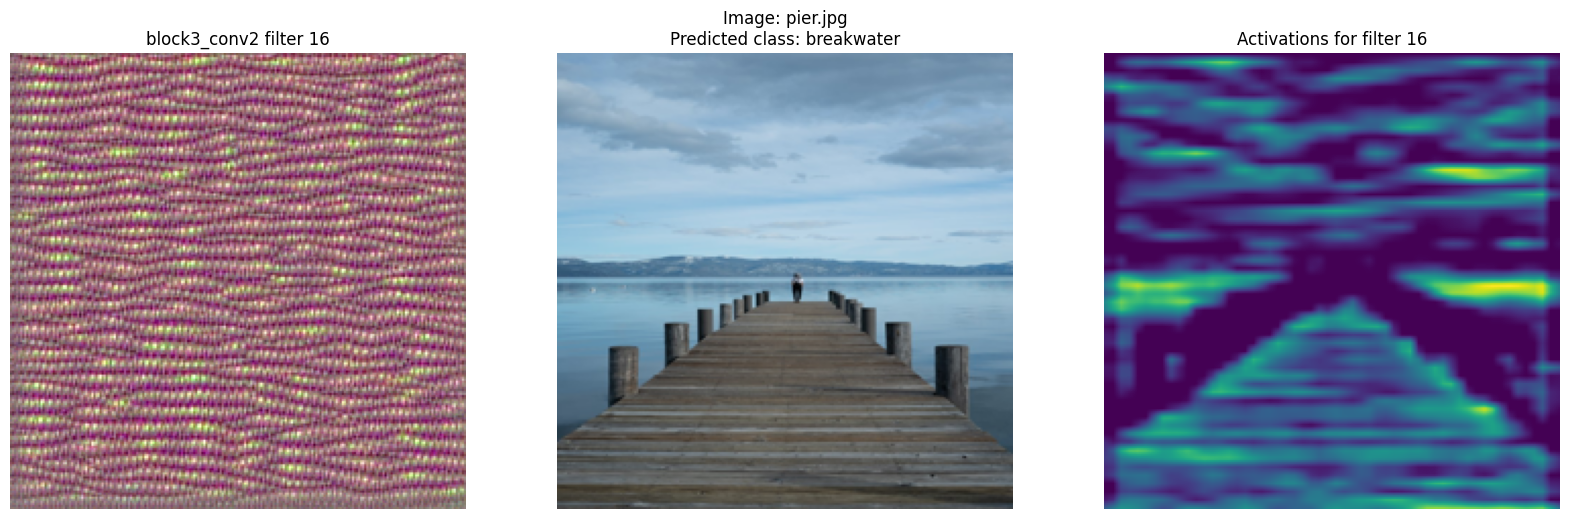

In [7]:
def plot_filter_image_and_activations(layer_name, filter_num, img_path):

    # Load the image
    img = Image.open(img_path).resize((224, 224))
    img_array = prepare_image_for_vgg(img)

    # Get the predictions
    preds = model.predict(img_array, verbose=0)
    label = decode_predictions(preds, top=1)[0][0][1]

    # Get the activations for the filter
    activation = intermediate_layer_model.predict(img_array, verbose=0)
    heatmap = activation[0, :, :, filter_num]
    heatmap = sp.ndimage.zoom(heatmap, (224/heatmap.shape[0], 224/heatmap.shape[1]), order=1)

    fig, axes = plt.subplots(1, 3, figsize=(20, 10))

    # Display the filter
    axes[0].imshow(generate_pattern(layer_name, filter_num))
    axes[0].set_title(f'{layer_name} filter {filter_num}')
    axes[0].axis('off')

    # Display the image
    axes[1].imshow(img)
    axes[1].set_title(f'Image: {os.path.basename(img_path)}\nPredicted class: {label}')
    axes[1].axis('off')

    # Display the activations as their own image
    axes[2].imshow(heatmap)
    axes[2].set_title(f'Activations for filter {filter_num}')
    axes[2].axis('off')

    plt.show()

img_path = 'pier.jpg'
# img_path = 'dog.jpg'
plot_filter_image_and_activations(layer_name, filter_num, img_path)


In [8]:
# load the ImageNet sample images from /ImageNet_Samples
# each image is class_name.JPEG

# load the images
path = 'ImageNet_Samples/'
images = []

for filename in os.listdir(path):
    img = Image.open(os.path.join(path, filename)).resize((224, 224))
    image_arr = prepare_image_for_vgg(img)
    if image_arr.shape != (1, 224, 224, 3):
        print(f"Skipping {filename} due to incorrect shape: {image_arr.shape}")
        continue
    images.append(image_arr)

# predict for each image and record the activations of block4_conv4 filter {filter_num}
# get the 5 images that excite that filter the most

activations = []
for img_arr in images:
    activation = intermediate_layer_model.predict(img_arr, verbose=0)
    activations.append(activation)

Next we run a dataset through VGG19 which contains one example of each class in the ImageNet dataset. This will help us get a diverse picture of what the filter is looking for and what type of images it is most excited by.

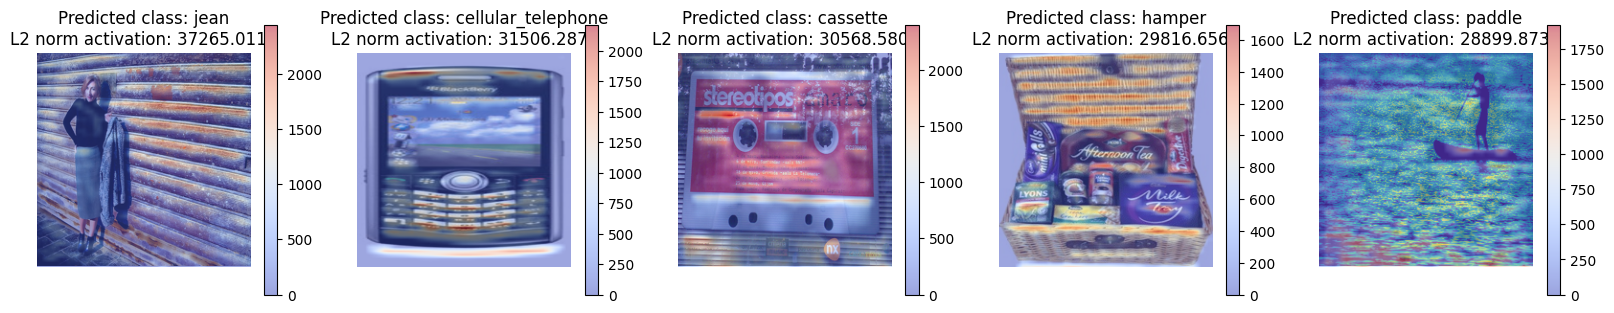

In [9]:
def l2_norm(activation):
    """
    Computes the L2 norm of an activation.
    :param activation: The 3D numpy array representing the activation
    :return: The L2 norm value
    """
    return np.sqrt(np.sum(np.square(activation)))

# Find the L2 norm of the activations for the specified filter
l2_norm_activations = [l2_norm(activation[:, :, :, filter_num]) for activation in activations]

# Get the indices of the top 5 images that excite the filter the most
top_5_indices = np.argsort(l2_norm_activations)[-5:][::-1]

# Plot the top 5 images with heatmaps using the L2 norm activation
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, index in enumerate(top_5_indices):
    img = Image.open(os.path.join(path, os.listdir(path)[index])).resize((224, 224))
    img_array = images[index]
    preds = model.predict(img_array, verbose=0)
    label = decode_predictions(preds, top=1)[0][0][1]
    activation = activations[index]
    heatmap = activation[0, :, :, filter_num]
    heatmap = sp.ndimage.zoom(heatmap, (224/heatmap.shape[0], 224/heatmap.shape[1]), order=1)

    plot_heatmap_on_image(img, heatmap, axes[i], cmap='coolwarm', alpha=0.5)
    axes[i].set_title(f'Predicted class: {label}\nL2 norm activation: {l2_norm_activations[index]:.4f}')
    axes[i].axis('off')

plt.show()


These images which maximally excite the filter are all of objects that have horizontal lines in them. This is a good sign that the filter is looking for horizontal lines.

## Analyzing Each Channel of the Filter

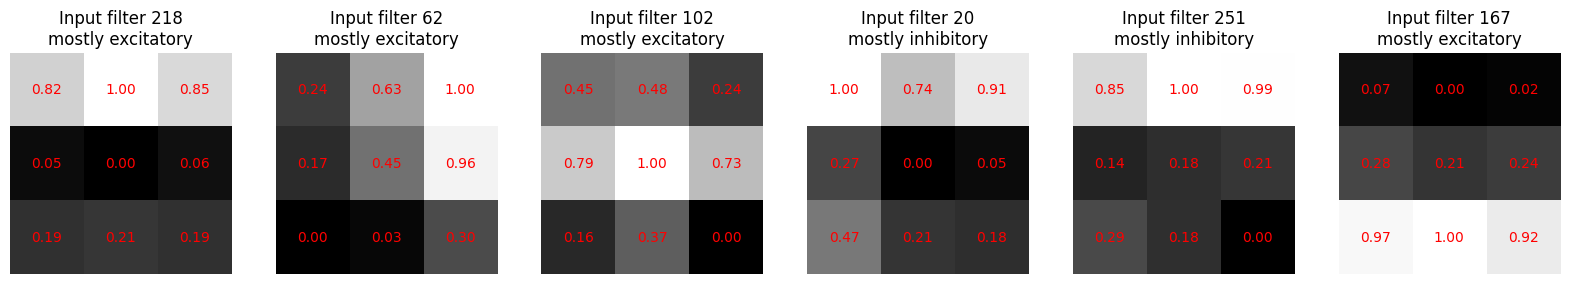

In [22]:
def get_filter_coefficients(layer_name, filter_num):
    # Get the layer object
    layer = model.get_layer(layer_name)

    # Get the layer's weights
    weights = layer.get_weights()[0]

    # Get the filter coefficients for the specified filter number
    filter_coefficients = weights[:, :, :, filter_num]

    return filter_coefficients

def get_top_six_strongest_filters(layer_name, filter_num):
    filter_coefficients = get_filter_coefficients(layer_name, filter_num)
    
    # Calculate the L2 norm for each input filter
    l2_norms = [l2_norm(filter_coefficients[:, :, i]) for i in range(filter_coefficients.shape[2])]
    
    # Get the indices of the top six strongest input filters
    top_six_indices = np.argsort(l2_norms)[-6:][::-1]
    
    return filter_coefficients[:, :, top_six_indices], top_six_indices

def categorize_filter(filter_coefficients):
    if np.mean(filter_coefficients) > 0:
        return "mostly excitatory"
    else:
        return "mostly inhibitory"

top_six_filters, top_six_filter_indices = get_top_six_strongest_filters(layer_name, filter_num)


fig, axes = plt.subplots(1, 6, figsize=(20, 5))

for i in range(6):
    filter_coefficients = top_six_filters[:, :, i]
    category = categorize_filter(filter_coefficients)
    
    # Normalize the filter coefficients for visualization
    normalized_filter = (filter_coefficients - filter_coefficients.min()) / (filter_coefficients.max() - filter_coefficients.min())
    
    axes[i].imshow(normalized_filter, cmap='gray')

    # annotate the filter heatmap
    for j in range(3):
        for k in range(3):
            text = axes[i].text(k, j, f'{normalized_filter[j, k]:.2f}',
                               ha="center", va="center", color="r")


    axes[i].set_title(f'Input filter {top_six_filter_indices[i] + 1}\n{category}')
    axes[i].axis('off')

plt.show()

In th code above we visualize the top 6 3x3 convoliutional filter channels from the 'block3_conv2' layer. We do so by first gettting the filter coeffecients for each channel in the model. We then find the top 6 strongest channel filters using l2 norm. Finally we visualise each channel and display its coeffeicents. The darker pixels represent smaller (more negative) weights, while the lighter pixels represent larger (more positive) weights. weWe categorize each of the top six input filters as "mostly inhibitory" if it has mostly contains pixels with smaller weights, and "mostly excitatory" if it has mostly contains pixels with larger weights.

## Visualiizing What Image Maximally Excites Each Channel Filter

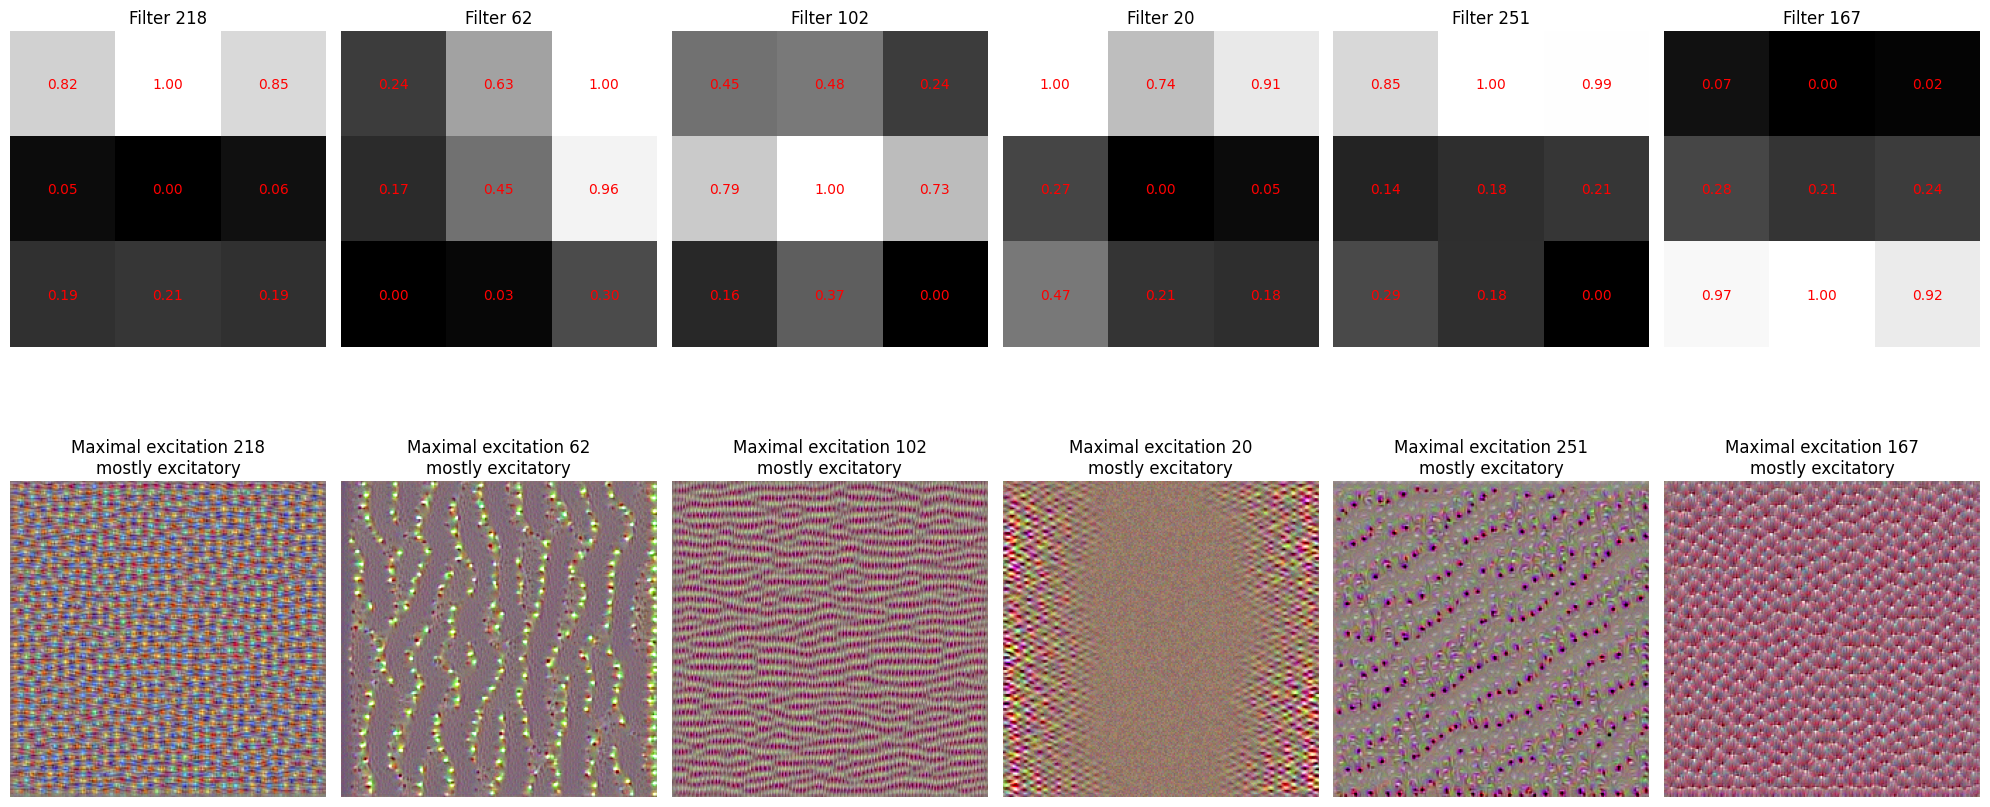

In [26]:
def generate_pattern_channel(layer_name, channel, size=224):
    layer_output = model.get_layer(layer_name).output
    new_model = models.Model(inputs=model.input, outputs=layer_output)
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    I_start = tf.Variable(input_img_data, name='image_var', dtype='float64')
    I = preprocess_input(I_start)

    eta = 1.
    for i in range(40):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(I)
            model_vals = new_model(I)
            loss = tf.reduce_mean(model_vals[:, :, :, channel])

        grad_fn = tape.gradient(loss, I)
        grad_fn /= (tf.sqrt(tf.reduce_mean(tf.square(grad_fn))) + 1e-5)
        I += grad_fn * eta

    img = I.numpy()
    return prepare_image_for_display(img, norm_type='std')

# layer before
prev_layer = 'block3_conv1'

# uses the same filters as selected int the last section


# plot each filter next to the corresponding channel
fig, axes = plt.subplots(2, 6, figsize=(20, 10))

for i, channel in enumerate(top_six_filter_indices):
    # Display the filter
    filter_coefficients = top_six_filters[:, :, i]
    normalized_filter = (filter_coefficients - filter_coefficients.min()) / (filter_coefficients.max() - filter_coefficients.min())

    # annotate the filter heatmap
    for j in range(3):
        for k in range(3):
            text = axes[0, i].text(k, j, f'{normalized_filter[j, k]:.2f}',
                               ha="center", va="center", color="r")

    axes[0, i].imshow(normalized_filter, cmap='gray')
    axes[0, i].set_title(f'Filter {top_six_filter_indices[i] + 1}')
    axes[0, i].axis('off')
    
    # Display the pattern that maximally excites the filter
    img = generate_pattern_channel(prev_layer, channel)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Maximal excitation {top_six_filter_indices[i] + 1}\n{category}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In the code above, we use gradient ascent to find the image that maximally excites each channel filter. Each of the channel filters images make sense for our multi channel filter. As we know our multi channel filter is excited by the pier, we see that many of the maximally excited images seem to correspond to images with horizontal lines. The second channel filter that we visualized shows vertical lines that are more spaced out. This makes sense as our pier image is flanked by vertical poles. Thhe fourth channel filter shows a distinciton between the middle and right and left sides of the image. This makes sense for our pier image as it is surrounded by water and the pier is in the middle. The other channel filters indicate activations for moslty horizontal and some diagonal lines.